# Pytorch Multi-output GPR

The purpose of this notebook is to predict the soil type and soil thickness of Layer 1 as a Multi-Output GP model using a ModelList. Unlike a Multi-Task model, Multi-Output models do not represent correlations between outcomes, but treat outcomes independently. 

#### Import libraries

In [1]:
!pip install torch --quiet
!pip install gpytorch --quiet

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import torch
import gpytorch
from gpytorch.models import ApproximateGP, ExactGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.likelihoods import SoftmaxLikelihood, GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

____________________

#### Load training data points

In [3]:
# Load the training data CSV file compiled in `1-data_access.ipynb`
input_file = '../data/2-uw_layer1_trainingdata.csv'
training_data = pd.read_csv(input_file)

# Create a GeoDataFrame from the DataFrame
training_data = gpd.GeoDataFrame(training_data, geometry=gpd.points_from_xy(training_data.LONGITUDE, training_data.LATITUDE))
    
# Set the CRS to WGS84 (latitude and longitude)
training_data.set_crs(epsg=4326, inplace=True)

training_data

,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,USCS,SIMPLE_USCS,LAYER_THICKNESS_FT,geometry,MAPPED_UNIT,SLOPE,ROUGHNESS
0,7138,B-1,Geotechnical,20.3,167.8,47.656719,-122.305728,1,0.0,1.0,SP,S,1.0,POINT (-122.30573 47.65672),Qvt,3.668571,18.199593
1,7143,B-1-92,Geotechnical,48.5,123.2,47.653642,-122.306837,1,0.0,1.0,ML,M,1.0,POINT (-122.30684 47.65364),Qvt,2.222722,10.232103
2,7144,B-2-92,Geotechnical,42.5,122.9,47.653766,-122.306468,1,0.0,1.0,ML,M,1.0,POINT (-122.30647 47.65377),Qvt,1.996012,9.385303
3,7145,B-3-92,Geotechnical,43.0,117.3,47.653256,-122.306638,1,0.0,1.0,ML,M,1.0,POINT (-122.30664 47.65326),Qvt,3.011285,14.187020
4,7146,B-4-92,Geotechnical,43.0,123.4,47.653709,-122.306259,1,0.0,0.5,SM,S,0.5,POINT (-122.30626 47.65371),Qvt,1.996012,9.385303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,143845,MW-1,Geotechnical,42.0,217.4,47.661044,-122.342453,1,0.0,7.5,SM,S,7.5,POINT (-122.34245 47.66104),Qvr,1.594538,10.106370
502,143846,MW-2,Geotechnical,43.0,218.2,47.661138,-122.342516,1,0.0,7.5,SM,S,7.5,POINT (-122.34252 47.66114),Qvr,1.340698,8.735672
503,143847,MW-3,Geotechnical,45.5,219.3,47.661276,-122.342492,1,0.0,18.0,SM,S,18.0,POINT (-122.34249 47.66128),Qvr,1.594538,10.106370
504,143848,MW-4,Geotechnical,43.0,219.1,47.661177,-122.342383,1,0.0,10.0,SM,S,10.0,POINT (-122.34238 47.66118),Qvr,1.594538,10.106370


____________________

#### Split train and test data

In [4]:
training_data.columns

Index(['BOREHOLE_ID', 'BOREHOLE_NAME', 'BOREHOLE_TYPE', 'BOREHOLE_DEPTH_FT',
       'ELEVATION_FT', 'LATITUDE', 'LONGITUDE', 'LAYER_NUMBER', 'TOP_DEPTH_FT',
       'BOTTOM_DEPTH_FT', 'USCS', 'SIMPLE_USCS', 'LAYER_THICKNESS_FT',
       'geometry', 'MAPPED_UNIT', 'SLOPE', 'ROUGHNESS'],
      dtype='object')

In [5]:
print(len(training_data))
training_data = training_data[training_data['USCS']!='CH']
training_data = training_data[training_data['USCS']!='GP-GM']

print(len(training_data))
# Assuming training_data is your DataFrame
X = training_data[['MAPPED_UNIT', 'SLOPE', 'ROUGHNESS']]
y_1 = training_data['USCS']
y_2 = training_data['LAYER_THICKNESS_FT']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['MAPPED_UNIT']),  # One-hot encode categorical features
        ('num', StandardScaler(), ['SLOPE', 'ROUGHNESS'])  # Standardize numerical features
    ])

# Apply transformations and convert to dense array
X_processed = preprocessor.fit_transform(X).toarray()  # Convert to array if sparse

# Convert processed data to tensors
X_tensor = torch.tensor(X_processed, dtype=torch.float32)
## When dataset gets large and the one-hot encoding results in a sparse matrix, consider using a sparse tensor in PyTorch. This can help with memory efficiency
# X_tensor = torch.tensor(X_processed.todense(), dtype=torch.float32) if scipy.sparse.issparse(X_processed) else torch.tensor(X_processed, dtype=torch.float32) 

# Handling target for SIMPLE_USCS
label_encoder = LabelEncoder()
y_1_encoded = label_encoder.fit_transform(y_1) # Ensure target is in integer form
y_1_tensor = torch.tensor(y_1_encoded, dtype=torch.long) # Convert to tensor

# Handling target for LAYER_THICKNESS_FT
scaler = StandardScaler()
y_2_scaled = scaler.fit_transform(y_2.values.reshape(-1, 1))
y_2_tensor = torch.tensor(y_2_scaled, dtype=torch.float32).squeeze() 

# Split the data into training and test sets for both models
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_tensor, y_1_tensor, test_size=0.2, random_state=42, stratify=y_1)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_tensor, y_2_tensor, test_size=0.2, random_state=42)

506
504


In [6]:
root = {} # empty dict for parent classes
root['G'] = 'Course'
root['S'] = 'Course'
root['M'] = 'Fine'
root['C'] = 'Fine'
root['O'] = 'Fine'
root['P'] = 'Organic'

root

{'G': 'Course',
 'S': 'Course',
 'M': 'Fine',
 'C': 'Fine',
 'O': 'Fine',
 'P': 'Organic'}

In [7]:
np.unique(label_encoder.inverse_transform(y_1_encoded))

array(['CL', 'GM', 'GP', 'GW', 'MH', 'ML', 'OH', 'OL', 'PT', 'SC', 'SM',
       'SP', 'SP-SM', 'SW', 'SW-SM'], dtype=object)

In [8]:
label_encoder.transform(['GM'])

array([1])

In [9]:
parent = {}
for i, label in enumerate(np.unique(label_encoder.inverse_transform(y_1_encoded))):
    parent[label] = label[0]
parent

{'CL': 'C',
 'GM': 'G',
 'GP': 'G',
 'GW': 'G',
 'MH': 'M',
 'ML': 'M',
 'OH': 'O',
 'OL': 'O',
 'PT': 'P',
 'SC': 'S',
 'SM': 'S',
 'SP': 'S',
 'SP-SM': 'S',
 'SW': 'S',
 'SW-SM': 'S'}

In [10]:
root = {}
root['G'] = 'Course'
root['S'] = 'Course'
root['M'] = 'Fine'    
root['C'] = 'Fine'
root['O'] = 'Fine'
root['P'] = 'Organic'

In [11]:
def custom_loss(ypred, ytrue):
    # evaluate results
    ycheck = ypred - ytrue
    
    # transform results
    ypred = label_encoder.inverse_transform(ypred)
    ytrue = label_encoder.inverse_transform(ytrue)

    print(ypred[0])
    
    sim, loss = 1, 0 # init similarity and loss values
    for i in range(len(ycheck)):
        parent_pred, parent_true = parent[ypred[i]], parent[ytrue[i]]
        root_pred, root_true = root[parent_pred], root[parent_true]
        
        if int(ycheck[i]) == 0:
            continue
        elif parent_pred == parent_true:
            sim = 0.5
        elif root_pred == root_true:
            sim = 0.25
        else:
            sim = 0

        loss += (1-sim)
        
    return loss

In [12]:
class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x, num_classes):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(self, train_x, variational_distribution, learn_inducing_locations=True)
        super(GPClassificationModel, self).__init__(variational_strategy)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.num_classes = num_classes

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x).expand([self.num_classes])

In [13]:
# Initialize the likelihood and model for multiclass classification
num_classes = len(label_encoder.classes_)
likelihood_1 = gpytorch.likelihoods.SoftmaxLikelihood(num_classes=num_classes, mixing_weights=None)
model_1 = GPClassificationModel(X_train_1, num_classes=num_classes)

# Initialize the likelihood and model for regression
# likelihood_2 = GaussianLikelihood()
# model_2 = GPRegressionModel(X_train_2, y_train_2, likelihood_2)

In [14]:
# Training settings
training_iter = 1000  # Number of training iterations
lr = 1  # Learning rate

# loss weights
elbo_weight = 0.9
custom_weight = 1-elbo_weight

model_1.train()
likelihood_1.train()

optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=lr)
mll_1 = gpytorch.mlls.VariationalELBO(likelihood_1, model_1, num_data=X_train_1.size(0))

# Implement Gradient Clipping
for i in range(training_iter):
    optimizer_1.zero_grad()
    output_1 = model_1(X_train_1)
    
    # Check for NaNs in the output
    if torch.isnan(output_1.mean).any():
        print(f"Warning: NaN detected in output at iteration {i + 1}")
        break

    prediction = model_1(X_train_1)
    predicted_probabilities = torch.softmax(prediction.mean, dim=0)
    predicted_labels = predicted_probabilities.argmax(dim=0).detach()
    
    sim_score = torch.ones(1, requires_grad=True)*custom_loss(predicted_labels, y_train_1)
    loss_1 = elbo_weight*(-mll_1(output_1, y_train_1)) + custom_weight*sim_score
    loss_1.backward()
    
    # Clip gradients
    torch.nn.utils.clip_grad_norm_(model_1.parameters(), max_norm=1.0)
    
    optimizer_1.step()
    print(f'Classification Model Iter {i + 1}/{training_iter} - Loss: {loss_1.item()}')

# Make predictions after training
model_1.eval()
likelihood_1.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood_1(model_1(X_test_1)).mean

# Check for NaN predictions
if torch.isnan(predictions).any():
    print("NaN detected in predictions!")
else:
    print("Predictions are valid.")

CL
Classification Model Iter 1/1000 - Loss: 41.4199104309082
CL
Classification Model Iter 2/1000 - Loss: 79.78706359863281
CL
Classification Model Iter 3/1000 - Loss: 109.98216247558594
CL
Classification Model Iter 4/1000 - Loss: 80.313720703125
CL
Classification Model Iter 5/1000 - Loss: 47.34782028198242
CL
Classification Model Iter 6/1000 - Loss: 58.726749420166016
CL
Classification Model Iter 7/1000 - Loss: 64.6380844116211
CL
Classification Model Iter 8/1000 - Loss: 55.5101432800293
CL
Classification Model Iter 9/1000 - Loss: 49.04360580444336
CL
Classification Model Iter 10/1000 - Loss: 50.3821907043457
CL
Classification Model Iter 11/1000 - Loss: 51.53897476196289
CL
Classification Model Iter 12/1000 - Loss: 49.79473876953125
CL
Classification Model Iter 13/1000 - Loss: 48.01490783691406
CL
Classification Model Iter 14/1000 - Loss: 48.11121368408203
CL
Classification Model Iter 15/1000 - Loss: 48.15381622314453
CL
Classification Model Iter 16/1000 - Loss: 46.323665618896484
CL
C

In [15]:
# Set models and likelihoods to evaluation mode
model_1.eval()
likelihood_1.eval()

# Make predictions (use a small batch from X_test_1 for diagnosis)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    small_X_test_1 = X_test_1[:5]  # Take the first 5 samples for a small test
    prediction = model_1(small_X_test_1)
    
    # Inspect the raw prediction mean before applying softmax
    print(f"Raw prediction mean (pre-softmax): {prediction.mean}")

    # Apply softmax and check the outputs
    predicted_probabilities = torch.softmax(prediction.mean, dim=0)
    print(f"Predicted probabilities: {predicted_probabilities}")

    predicted_labels = predicted_probabilities.argmax(dim=0).detach().numpy()
    print(f"Predicted labels: {predicted_labels}")

# If everything seems fine in the small batch, proceed with the full prediction
if not torch.isnan(prediction.mean).any():
    print("Small batch predictions are valid, proceeding with full test set.")
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        full_prediction = model_1(X_test_1)
        full_predicted_probabilities = torch.softmax(full_prediction.mean, dim=0)
        if torch.isnan(full_predicted_probabilities).any():
            print("NaN detected in full predictions!")
        else:
            full_predicted_labels = full_predicted_probabilities.argmax(dim=0).detach().numpy()
            print(f"Full predicted labels: {full_predicted_labels}")
else:
    print("NaN detected in small batch predictions!")

Raw prediction mean (pre-softmax): tensor([[11.2274, 11.2274, 11.2274, 11.2274, 11.2274],
        [11.2274, 11.2274, 11.2274, 11.2274, 11.2274],
        [11.2274, 11.2274, 11.2274, 11.2274, 11.2274],
        [11.2274, 11.2274, 11.2274, 11.2274, 11.2274],
        [11.2274, 11.2274, 11.2274, 11.2274, 11.2274],
        [11.2274, 11.2274, 11.2274, 11.2274, 11.2274],
        [11.2274, 11.2274, 11.2274, 11.2274, 11.2274],
        [11.2274, 11.2274, 11.2274, 11.2274, 11.2274],
        [11.2274, 11.2274, 11.2274, 11.2274, 11.2274],
        [11.2274, 11.2274, 11.2274, 11.2274, 11.2274],
        [11.2274, 11.2274, 11.2274, 11.2274, 11.2274],
        [11.2274, 11.2274, 11.2274, 11.2274, 11.2274],
        [11.2274, 11.2274, 11.2274, 11.2274, 11.2274],
        [11.2274, 11.2274, 11.2274, 11.2274, 11.2274],
        [11.2274, 11.2274, 11.2274, 11.2274, 11.2274]])
Predicted probabilities: tensor([[0.0667, 0.0667, 0.0667, 0.0667, 0.0667],
        [0.0667, 0.0667, 0.0667, 0.0667, 0.0667],
        [0.066

Text(0.5, 1.0, 'true')

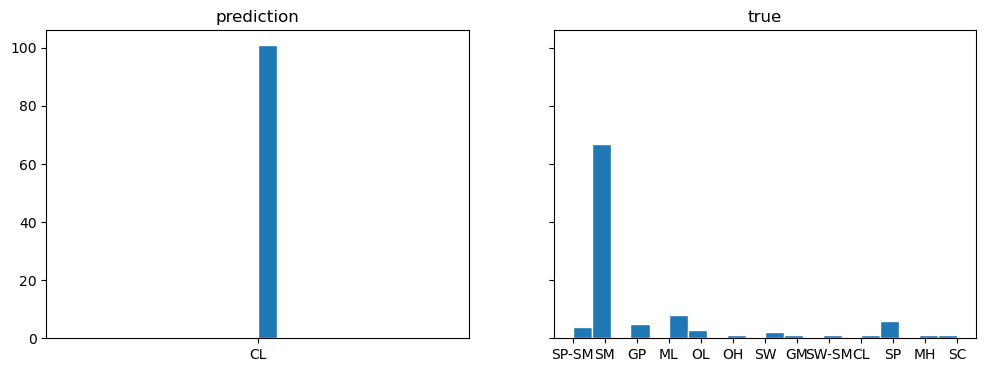

In [16]:
preds = label_encoder.inverse_transform(full_predicted_labels)
trues = label_encoder.inverse_transform(y_test_1)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axs[0].hist(preds, edgecolor='white', bins=20)
axs[0].set_title('prediction')
axs[1].hist(trues, edgecolor='white', bins=20)
axs[1].set_title('true')

____________________

Sources:
1. https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/ModelList_GP_Regression.html
2. https://jamesbrind.uk/posts/2d-gaussian-process-regression/